In [ ]:
# Installing required packages
!pip3 install pyspark
!pip3 install findspark
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn

In [1]:
import findspark
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr,when
from pyspark.sql.functions import countDistinct
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

findspark.init()

In [2]:
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

23/06/09 01:33:54 WARN Utils: Your hostname, Mazens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.18 instead (on interface en0)
23/06/09 01:33:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/09 01:33:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
egphotelbookings = pd.read_csv('dataset.csv')
sdf = spark.createDataFrame(egphotelbookings) 
sdf.printSchema()
#sdf.show(10)
#print('Rows',sdf.count()) 

print(len(sdf.columns))
print(sdf.count())

root
 |-- Unnamed: 0: long (nullable = true)
 |-- hotel: string (nullable = true)
 |-- is_canceled: long (nullable = true)
 |-- lead_time: long (nullable = true)
 |-- arrival_date_year: long (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: long (nullable = true)
 |-- arrival_date_day_of_month: long (nullable = true)
 |-- stays_in_weekend_nights: long (nullable = true)
 |-- stays_in_week_nights: long (nullable = true)
 |-- adults: long (nullable = true)
 |-- children: double (nullable = true)
 |-- babies: long (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: long (nullable = true)
 |-- previous_cancellations: long (nullable = true)
 |-- previous_bookings_not_canceled: long (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: long (nul

23/06/09 01:34:25 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/06/09 01:34:26 WARN TaskSetManager: Stage 0 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


119390


In [4]:
sdf = sdf.dropDuplicates()

#here i am droping any column with more than 50 % pf null
threshold = sdf.count() * 0.5
sdf = sdf.drop(*[column for column in sdf.columns if sdf.where(col(column).isNull()).count() > threshold])

#here i am droping rows with more than 10 missing values
sdf = sdf.dropna(thresh=10)

#making new column with total nbr of guests
sdf = sdf.withColumn("total_guests", col("adults").cast(IntegerType()) + col("children").cast(IntegerType()) + col("babies").cast(IntegerType()))

sdf = sdf.withColumn("total_stays", col("stays_in_weekend_nights") + col("stays_in_week_nights"))

#droping rows xith guests = 0 or days stayd = 0
sdf = sdf.filter(col("total_stays") != 0)
sdf = sdf.filter(col("total_guests") != 0)

#making new column booking_canceled as a boolean to easily now if a booking got cancelled
#to be used in the ML models
#sdf = sdf.withColumn


# converting the categorical arrival_date_month to numerical
string_indexer = StringIndexer(inputCol='arrival_date_month', outputCol='month_nubr')
model = string_indexer.fit(sdf)
sdf = model.transform(sdf)


# drop the columns with only one unique value
for column in sdf.columns:
    unique_count = sdf.select(countDistinct(column)).collect()[0][0]
    if unique_count == 1:
        print(column)
        sdf = sdf.drop(column)


print(len(sdf.columns))
print(sdf.count())

23/06/09 01:34:36 WARN TaskSetManager: Stage 3 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:34:38 WARN TaskSetManager: Stage 9 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:34:39 WARN TaskSetManager: Stage 12 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:34:39 WARN TaskSetManager: Stage 15 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:34:39 WARN TaskSetManager: Stage 18 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:34:40 WARN TaskSetManager: Stage 21 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:34:40 WARN TaskSetManager: Stage 24 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09

33


23/06/09 01:35:07 WARN TaskSetManager: Stage 307 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


118565


In [5]:
sdf.createTempView("Hotels")

***-Promotions for Renaissance Hotel***

based on the following three code cells We suggest:

1- a policy for the hotel that if the customer is staying more than 5 days he needs to pay a deposit  because aproximately 40-50% of those who stays more than 5 days cancels there booking

2- Since the number of repeated guests is low we suggest that the hotel gives the customers percentage (10%) discount for their next booking to encourage them to book in the hotel again  

3- As we observe below, The main distribution channel is TA/TO for this hotel so we suggest giving a percentage of the profit to the TA/TO to encourage them to keep using this hotel in the future 

In [6]:
rows = spark.sql("SELECT * FROM Hotels WHERE hotel = 'Renaissance Hotel' AND total_stays > 5 AND deposit_type = 'No Deposit' AND is_canceled = 1")
rows2 = spark.sql("SELECT * FROM Hotels WHERE hotel = 'Renaissance Hotel' AND total_stays > 5 AND deposit_type = 'No Deposit' AND is_canceled = 0")

print("Number of customers staying more than five days and doesn't pay a deposit then canceled their booking:",rows.count())
print("Number of customers staying more than five days and doesn't pay a deposit but didn't cancel the booking:",rows2.count())
#We suggest a policy for the hotel that if the customer is staying more than 5 days he needs to pay a deposit 
#because aproximately 40-50% of those who stays more than 5 days cancels there booking


23/06/09 01:35:08 WARN TaskSetManager: Stage 313 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


Number of customers staying more than five days and doesn't pay a deposit then canceled their booking: 3573


23/06/09 01:35:09 WARN TaskSetManager: Stage 319 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


Number of customers staying more than five days and doesn't pay a deposit but didn't cancel the booking: 8423


In [7]:
rows = spark.sql("SELECT * FROM Hotels WHERE hotel = 'Renaissance Hotel' AND is_repeated_guest = 0")
rows2 = spark.sql("SELECT * FROM Hotels WHERE hotel = 'Renaissance Hotel' AND is_repeated_guest > 0")

print("number of non-repeated guests:",rows.count())
print("number of repeated guests:",rows2.count())
#Since the number of repeated guests is low we suggest that the hotel gives the customers percentage (10%) discount for their next booking
#to encourage them to book in the hotel again  

23/06/09 01:35:09 WARN TaskSetManager: Stage 325 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:35:10 WARN TaskSetManager: Stage 331 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


number of non-repeated guests: 37999
number of repeated guests: 1667


In [8]:
spark.sql("SELECT COUNT(distribution_channel) AS count ,distribution_channel FROM Hotels WHERE hotel = 'Renaissance Hotel' GROUP BY distribution_channel ORDER BY COUNT(distribution_channel) DESC").show()
#As we observe below, The main distribution channel is TA/TO for this hotel so we suggest giving a percentage of the profit to
#the TA/TO to encourage them to keep using this hotel in the future  

23/06/09 01:35:11 WARN TaskSetManager: Stage 337 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+
|count|distribution_channel|
+-----+--------------------+
|28673|               TA/TO|
| 7773|              Direct|
| 3219|           Corporate|
|    1|           Undefined|
+-----+--------------------+



***-Promotions for JW Marriott Hotel***

based on the following three code cells  we suggest:

1- offers in the less stayed months like January to attract more customers 

2-offering an upgrade meal for customers booking more than a week (So if a customer booked a week or more he gets FB which is full board course meal)

3-the hotel to make a place for a baby daycare to encourage more families to book in the hotel

In [9]:
rows = spark.sql("SELECT SUM(total_stays) AS Days_Stayed ,arrival_date_month AS Month FROM Hotels WHERE hotel = 'JW Marriott Hotel' GROUP BY arrival_date_month ORDER BY SUM(total_stays) DESC").show()
#We suggest that the hotel makes offers in the less stayed months like January to attract more customers  

23/06/09 01:35:12 WARN TaskSetManager: Stage 343 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


+-----------+---------+
|Days_Stayed|    Month|
+-----------+---------+
|      28263|   August|
|      25320|     July|
|      23342|      May|
|      22756|     June|
|      22753|    April|
|      20826|  October|
|      20602|September|
|      19587|    March|
|      14774| February|
|      13226| December|
|      12882| November|
|      11174|  January|
+-----------+---------+



In [10]:
rows = spark.sql("SELECT count(*) AS Num_of_customers_staying_more_than_7_days ,meal FROM Hotels WHERE hotel = 'JW Marriott Hotel' AND total_stays >= 7 GROUP BY meal ORDER BY COUNT(meal) DESC").show()
rows2 = spark.sql("SELECT count(*) AS Num_of_customers_staying_less_than_or_equal_to_7_days ,meal FROM Hotels WHERE hotel = 'JW Marriott Hotel' AND total_stays < 7 GROUP BY meal ORDER BY COUNT(meal) DESC").show()

#We suggest offering an upgrade meal for customers booking more than a week 
#(So if a customer booked a week or more he gets FB which is full board course meal)

23/06/09 01:35:13 WARN TaskSetManager: Stage 349 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


+-----------------------------------------+----+
|Num_of_customers_staying_more_than_7_days|meal|
+-----------------------------------------+----+
|                                     2556|  BB|
|                                      454|  SC|
|                                      264|  HB|
+-----------------------------------------+----+



23/06/09 01:35:14 WARN TaskSetManager: Stage 355 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


+-----------------------------------------------------+----+
|Num_of_customers_staying_less_than_or_equal_to_7_days|meal|
+-----------------------------------------------------+----+
|                                                59493|  BB|
|                                                 9976|  SC|
|                                                 6112|  HB|
|                                                   44|  FB|
+-----------------------------------------------------+----+



In [11]:
rows = spark.sql("SELECT * FROM Hotels WHERE hotel = 'JW Marriott Hotel' AND babies > 0")
rows2 = spark.sql("SELECT * FROM Hotels WHERE hotel = 'JW Marriott Hotel' AND babies = 0")

print("Number of customers having babies with them:",rows.count())
print("Number of customers doesn't have babies with them:",rows2.count())
#We suggest the hotel to make a place for a baby daycare to encourage more families to book in the hotel

23/06/09 01:35:15 WARN TaskSetManager: Stage 361 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


Number of customers having babies with them: 366


23/06/09 01:35:15 WARN TaskSetManager: Stage 367 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


Number of customers doesn't have babies with them: 78533


***insights about attributes from the dataset using appropriate visualizations***
- https://www.kaggle.com/code/araspirbadian/hotel-booking-visualization is a refrence that we used

**now from the following we got that august is the month with most bookings and also with most cancellations and a lot of bookings in April and June and May and January gets cancelled**

23/06/09 01:35:20 WARN TaskSetManager: Stage 373 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


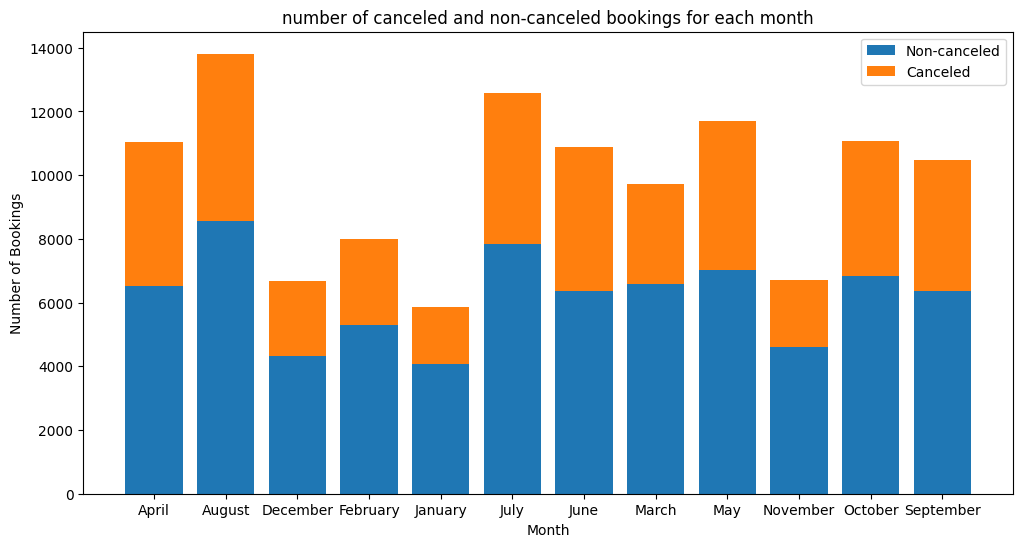

In [12]:
#counting the number of bookings by every month to get the months with most traffic on bookings and also considering the cancellation
visualize1 = sdf.groupBy("arrival_date_month", "is_canceled").count().orderBy("arrival_date_month").toPandas()

# Prepare the data for plotting
months = visualize1["arrival_date_month"].unique()
canceled_counts = visualize1[visualize1["is_canceled"] == 1]["count"]
non_canceled_counts = visualize1[visualize1["is_canceled"] == 0]["count"]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(months, non_canceled_counts, label='Non-canceled')
plt.bar(months, canceled_counts, bottom=non_canceled_counts, label='Canceled')
plt.xlabel("Month")
plt.ylabel("Number of Bookings")
plt.title("number of canceled and non-canceled bookings for each month")
plt.legend()
plt.show()

**From the following visualization we can know that when we have 12 guest they stay a lot of time (the most)**

23/06/09 01:35:27 WARN TaskSetManager: Stage 386 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


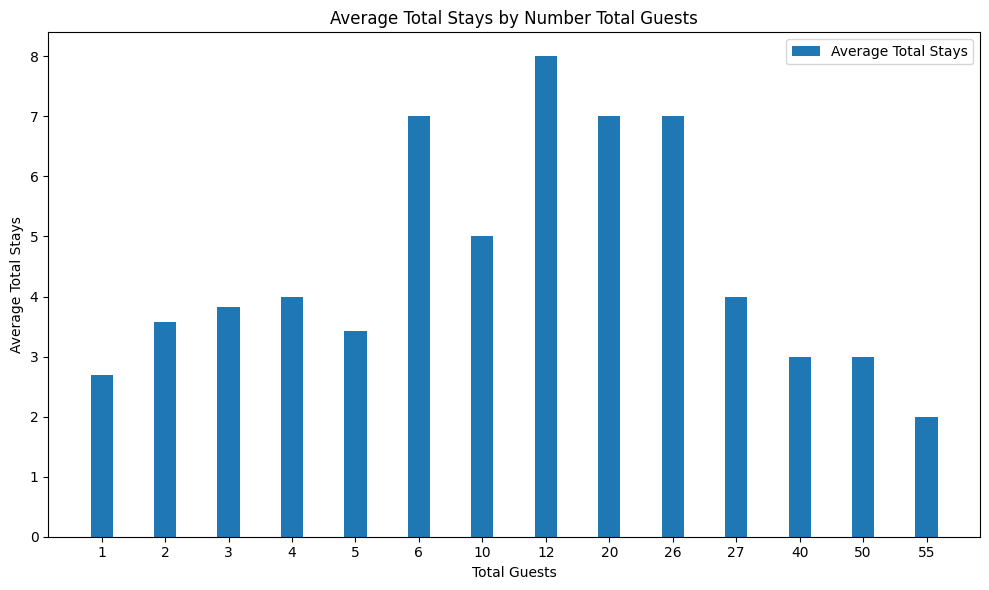

In [13]:
# Extract the relevant columns from the DataFrame
df = sdf.select("total_guests", "total_stays").toPandas()

# Group the data by the number of total guests and calculate the average total stays
grouped_data = df.groupby("total_guests").mean("total_stays").reset_index()

# Create a grouped bar chart to compare the average total stays for different number of total guests
x = np.arange(len(grouped_data))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, grouped_data["total_stays"], bar_width, label="Average Total Stays")
plt.xlabel("Total Guests")
plt.ylabel("Average Total Stays")
plt.title("Average Total Stays by Number Total Guests")
plt.xticks(x, grouped_data["total_guests"])
plt.legend()
plt.tight_layout()
plt.show()


 **we get from the following visualization that portugal is the country with most number of bookings**

23/06/09 01:35:33 WARN TaskSetManager: Stage 389 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


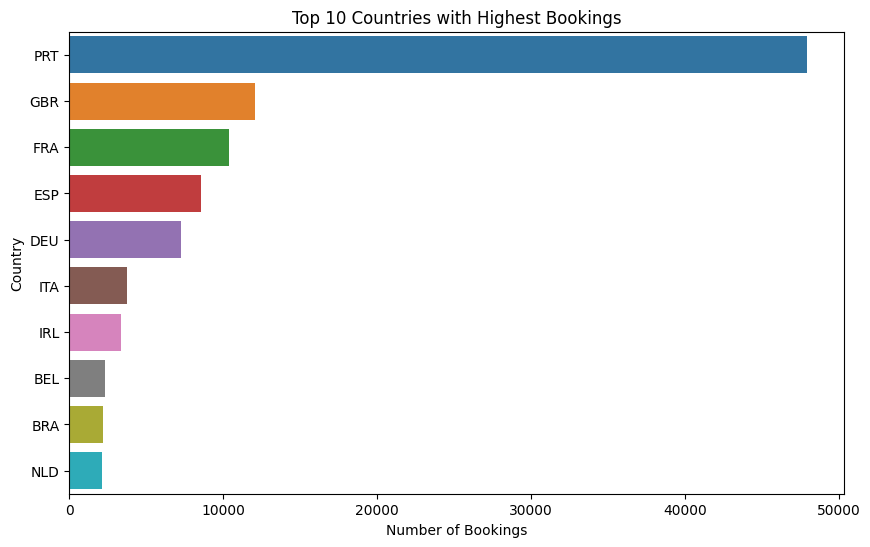

In [14]:
# counting the number of bookings in every country
country_bookings = sdf.groupBy("country").count().orderBy("count", ascending=False).limit(10)

country_bookings_pd = country_bookings.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="country", data=country_bookings_pd)
plt.xlabel("Number of Bookings")
plt.ylabel("Country")
plt.title("Top 10 Countries with Highest Bookings")
plt.show()




**the following graph shows that JW marriott is more international than Renaissance** 

23/06/09 01:35:38 WARN TaskSetManager: Stage 395 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


Text(0.5, 1.0, 'Count of Hotels for Each Country')

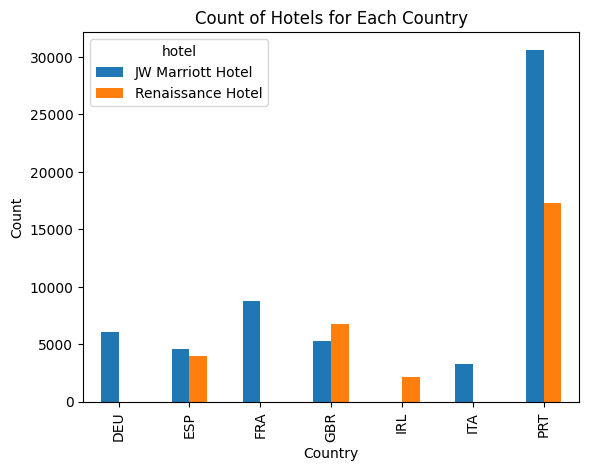

In [15]:
country_bookings = sdf.groupBy("country" , "hotel").count().orderBy("count", ascending=False).limit(10)

country_bookings_pd = country_bookings.toPandas()



df = pd.DataFrame(country_bookings_pd)

country_hotel_counts = df.groupby(['country', 'hotel'])['count'].sum()

pivot_table = country_hotel_counts.unstack()

pivot_table.plot(kind='bar')

plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Hotels for Each Country')

***Four ML models to predict wether the booking will get cancelled or not***

- using indexers - encoder - assembler that way i did it with help of this refrence https://stackoverflow.com/questions/63453146/how-to-handle-string-indexer-and-onehot-encoder-in-pyspark-pipeline-stages

- and also pyspark.ml documentation https://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html

In [39]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LinearSVC

#slecting the columns that i will use i tried selecting more columns but it only increase complexity and dosnt affect scores that much
#so these are the columns with influence on the performance of the models
data = sdf.select("hotel","previous_cancellations","previous_bookings_not_canceled","customer_type","total_of_special_requests","is_canceled", "adr", "lead_time", "arrival_date_week_number","month_nubr", "total_guests","total_stays","deposit_type")


# converting categorical columns to numerical 
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in ["hotel", "deposit_type","customer_type"]]
encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], outputCols=["hotel_cat", "deposit_type_cat","customer_type_cat"])

assembler = VectorAssembler(inputCols=["hotel_cat","previous_cancellations","previous_bookings_not_canceled","customer_type_cat","total_of_special_requests","lead_time","month_nubr","arrival_date_week_number", "adr", "total_guests", "total_stays", "deposit_type_cat"], outputCol="features")


train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

#evaluating the models using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="is_canceled")


23/06/09 01:44:28 WARN TaskSetManager: Stage 5331 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:44:29 WARN TaskSetManager: Stage 5337 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:44:29 WARN TaskSetManager: Stage 5343 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


In [40]:

svm = LinearSVC(labelCol="is_canceled", featuresCol="features")
#fiting the pipeline on training data
pipeline_svm = Pipeline(stages=indexers + [encoder, assembler, svm])
model_svm = pipeline_svm.fit(train_data)
#predicting on the test data
predictions_svm = model_svm.transform(test_data)
#evaluating our model
score = evaluator.evaluate(predictions_svm)
print("SVM : ", score)

23/06/09 01:44:34 WARN TaskSetManager: Stage 5349 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:44:34 WARN TaskSetManager: Stage 5350 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:44:55 WARN TaskSetManager: Stage 6557 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:44:56 WARN TaskSetManager: Stage 6558 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:44:56 WARN TaskSetManager: Stage 6559 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


SVM :  0.7890536614153586


In [41]:
Logistic = LogisticRegression(labelCol="is_canceled", featuresCol="features")
pipeline = Pipeline(stages=indexers + [encoder, assembler, Logistic])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)
score = evaluator.evaluate(prediction)
print("Logistic Regression:", score)

23/06/09 01:45:01 WARN TaskSetManager: Stage 6575 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:02 WARN TaskSetManager: Stage 6576 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:06 WARN TaskSetManager: Stage 6736 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:07 WARN TaskSetManager: Stage 6737 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:07 WARN TaskSetManager: Stage 6738 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


Logistic Regression: 0.8114921986578606


In [42]:
Forest = RandomForestClassifier(labelCol="is_canceled", featuresCol="features")
pipeline = Pipeline(stages=indexers + [encoder, assembler, Forest])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)
score = evaluator.evaluate(prediction)
print("Random Forest :", score)

23/06/09 01:45:11 WARN TaskSetManager: Stage 6754 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:11 WARN TaskSetManager: Stage 6755 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:12 WARN TaskSetManager: Stage 6761 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:15 WARN TaskSetManager: Stage 6784 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:15 WARN TaskSetManager: Stage 6785 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:16 WARN TaskSetManager: Stage 6786 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


Random Forest : 0.8279049416555961


In [43]:
Gradient = GBTClassifier(labelCol="is_canceled", featuresCol="features")
pipeline = Pipeline(stages=indexers + [encoder, assembler, Gradient])
model = pipeline.fit(train_data)
prediction = model.transform(test_data)
score = evaluator.evaluate(prediction)
print("Gradient Boosted Trees :", score)

23/06/09 01:45:21 WARN TaskSetManager: Stage 6802 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:22 WARN TaskSetManager: Stage 6803 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.
23/06/09 01:45:30 WARN TaskSetManager: Stage 7111 contains a task of very large size (1337 KiB). The maximum recommended task size is 1000 KiB.


Gradient Boosted Trees : 0.8425790268864483
